# Floating-point arithmetic

As a data analyst, you will be concerned primarily with _numerical programs_ in which the bulk of the computational work involves floating-point computation. This notebook guides you through some of the most fundamental concepts in how computers store real numbers, so you can be smarter about your number crunching.

## WYSInnWYG, or "what you see is not necessarily what you get."

One important consequence of a binary format is that when you print values in base ten, what you see may not be what you get! For instance, try running the code below.

> This code invokes Python's [`decimal`](https://docs.python.org/3/library/decimal.html) package, which implements base-10 floating-point arithmetic in software.

In [1]:
from decimal import Decimal
?Decimal # Asks for a help page on the Decimal() constructor

In [2]:
x = 1.0 + 2.0**(-52)

print(x)
print(Decimal(x)) # What does this do?

print(Decimal(0.1) - Decimal('0.1')) # Why does the output appear as it does?

1.0000000000000002
1.0000000000000002220446049250313080847263336181640625
5.551115123125782702118158340E-18


> Aside: If you ever need true decimal storage with no loss of precision (e.g., an accounting application), turn to the `decimal` package. Just be warned it might be slower. See the following experiment for a practical demonstration.

In [3]:
from random import random

NUM_TRIALS = 2500000

print("Native arithmetic:")
A_native = [random() for _ in range(NUM_TRIALS)]
B_native = [random() for _ in range(NUM_TRIALS)]
%timeit [a+b for a, b in zip(A_native, B_native)]

print("\nDecimal package:")
A_decimal = [Decimal(a) for a in A_native]
B_decimal = [Decimal(b) for b in B_native]
%timeit [a+b for a, b in zip(A_decimal, B_decimal)]

Native arithmetic:
209 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Decimal package:
667 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**The same and not the same.** Consider the following two program fragments:

_Program 1_:

    s = a - b
    t = s + b
    
_Program 2_:

    s = a + b
    t = s - b

Let $a=1.0$ and $b=\epsilon_d / 2 \approx 1.11 \times 10^{-16}$, i.e., machine epsilon for IEEE-754 double-precision. Recall that we do not expect these programs to return the same value; let's run some Python code to see.

> Note: The IEEE standard guarantees that given two finite-precision floating-point values, the result of applying any binary operator to them is the same as if the operator were applied in infinite-precision and then rounded back to finite-precision. The precise nature of rounding can be controlled by so-called _rounding modes_; the default rounding mode is "[round-half-to-even](http://en.wikipedia.org/wiki/Rounding)."

In [3]:
a = 1.0
b = 2.**(-53) # == $\epsilon_d$ / 2.0

s1 =  a - b
t1 = s1 + b

s2 =  a + b
t2 = s2 - b

print("s1:", s1.hex())
print("t1:", t1.hex())
print("\n")
print("s2:", s2.hex())
print("t2:", t2.hex())

print("")
print(t1, "vs.", t2)
print("(t1 == t2) == {}".format(t1 == t2))

s1: 0x1.fffffffffffffp-1
t1: 0x1.0000000000000p+0


s2: 0x1.0000000000000p+0
t2: 0x1.fffffffffffffp-1

1.0 vs. 0.9999999999999999
(t1 == t2) == False


By the way, the NumPy/SciPy package, which we will cover later in the semester, allows you to determine machine epsilon in a portable way. Just note this fact for now.

Here is an example of printing machine epsilon for both single-precision and double-precision values.

In [7]:
import numpy as np

EPS_S = np.finfo (np.float32).eps
EPS_D = np.finfo (float).eps

print("Single-precision machine epsilon:", float(EPS_S).hex(), "~", EPS_S)
print("Double-precision machine epsilon:", float(EPS_D).hex(), "~", EPS_D)

Single-precision machine epsilon: 0x1.0000000000000p-23 ~ 1.19209e-07
Double-precision machine epsilon: 0x1.0000000000000p-52 ~ 2.22044604925e-16


## Analyzing floating-point programs

Let's say someone devises an algorithm to compute $f(x)$. For a given value $x$, let's suppose this algorithm produces the value $\mathrm{alg}(x)$. One important question might be, is that output "good" or "bad?"

**Forward stability.** One way to show that the algorithm is good is to show that

$$
  \left| \mathrm{alg}(x) - f(x) \right|
$$

is "small" for all $x$ of interest to your application. What is small depends on context. In any case, if you can show it then you can claim that the algorithm is _forward stable_.

**Backward stability.** Sometimes it is not easy to show forward stability directly. In such cases, you can also try a different technique, which is to show that the algorithm is, instead, _backward stable_.

In particular, $\mathrm{alg}(x)$ is a _backward stable algorithm_ to compute $f(x)$ if, for all $x$, there exists a "small" $\Delta x$ such that

$$\mathrm{alg}(x) = f(x + \Delta x).$$

In other words, if you can show that the algorithm produces the exact answer to a slightly different input problem (meaning $\Delta x$ is small, again in a context-dependent sense), then you can claim that the algorithm is backward stable.

**Round-off errors.** You already know that numerical values can only be represented finitely, which introduces round-off error. Thus, at the very least we should hope that a scheme to compute $f(x)$ is as insensitive to round-off errors as possible. In other words, given that there will be round-off errors, if you can prove that $\mathrm{alg}(x)$ is either forward or backward stable, then that will give you some measure of confidence that your algorithm is good.

Here is the "standard model" of round-off error. Start by assuming that every scalar floating-point operation incurs some bounded error. That is, let $a \odot b$ be the exact mathematical result of some operation on the inputs, $a$ and $b$, and let $\mathrm{fl}(a \odot b)$ be the _computed_ value, after rounding in finite-precision. The standard model says that

$$\mathrm{fl}(a \odot b) \equiv (a \odot b) (1 + \delta),$$

where $|\delta| \leq \epsilon$, machine epsilon.

Let's apply these concepts on an example.

## Example: Computing a sum

Let $x \equiv (x_0, \ldots, x_{n-1})$ be a collection of input data values. Suppose we wish to compute their sum.

The exact mathematical result is

$$
  f(x) \equiv \sum_{i=0}^{n-1} x_i.
$$

Given $x$, let's also denote its exact sum by the synonym $s_{n-1} \equiv f(x)$.
  
Now consider the following Python program to compute its sum:

In [4]:
def alg_sum(x): # x == x[:n]
    s = 0.
    for x_i in x: # x_0, x_1, \ldots, x_{n-1}
        s += x_i
    return s

In exact arithmetic, meaning without any rounding errors, this program would compute the exact sum. (See also the note below.) However, you know that finite arithmetic means there will be some rounding error after each addition.

Let $\delta_i$ denote the (unknown) error at iteration $i$. Then, assuming the collection `x` represents the input values exactly, you can show that `alg_sum(x)` computes $\hat{s}_{n-1}$ where

$$
  \hat{s}_{n-1} \approx s_{n-1} + \sum_{i=0}^{n-1} s_i \delta_i,
$$

that is, the exact sum _plus_ a perturbation, which is the second term (the sum). The question, then, is under what conditions will this sum will be small?

Using a *backward error analysis*, you can show that

$$
  \hat{s}_{n-1} \approx \sum_{i=0}^{n-1} x_i(1 + \Delta_i) = f(x + \Delta),
$$

where $\Delta \equiv (\Delta_0, \Delta_1, \ldots, \Delta_{n-1})$. In other words, the computed sum is the exact solution to a slightly different problem, $x + \Delta$.

To complete the analysis, you can at last show that

$$
  |\Delta_i| \leq (n-i) \epsilon,
$$

where $\epsilon$ is machine precision. Thus, as long as $n \epsilon \ll 1$, then the algorithm is backward stable and you should expect the computed result to be close to the true result. Interpreted differently, as long as you are summing $n \ll \frac{1}{\epsilon}$ values, then you needn't worry about the accuracy of the computed result compared to the true result:

In [7]:
print("Single-precision: 1/epsilon_s ~= {:.1f} million".format(1e-6 / EPS_S))
print("Double-precision: 1/epsilon_d ~= {:.1f} quadrillion".format(1e-15 / EPS_D))

Single-precision: 1/epsilon_s ~= 8.4 million
Double-precision: 1/epsilon_d ~= 4.5 quadrillion


Based on this result, you can probably surmise why double-precision is usually the default in many languages.

In the case of this summation, we can quantify not just the _backward error_ (i.e., $\Delta_i$) but also the _forward error_. In that case, it turns out that

$$
  \left| \hat{s}_{n-1} - s_{n-1} \right| \lessapprox n \epsilon \|x\|_1.
$$

> **Note: Analysis in exact arithmetic.** We claimed above that `alg_sum()` is correct _in exact arithmetic_, i.e., in the absence of round-off error. You probably have a good sense of that just reading the code.
>
> However, if you wanted to argue about its correctness more formally, you might do so as follows using the technique of [proof by induction](https://en.wikipedia.org/wiki/Mathematical_induction). When your loops are more complicated and you want to prove that they are correct, you can often adapt this technique to your problem.
>
> First, assume that the `for` loop enumerates each element `p[i]` in order from `i=0` to `n-1`, where `n=len(p)`. That is, assume `p_i` is `p[i]`.
>
> Let $p_k \equiv \mathtt{p[}k\mathtt{]}$ be the $k$-th element of `p[:]`. Let $s_i \equiv \sum_{k=0}^{i} p_k$; in other words, $s_i$ is the _exact_ mathematical sum of `p[:i+1]`. Thus, $s_{n-1}$ is the exact sum of `p[:]`.
>
> Let $\hat{s}_{-1}$ denote the initial value of the variable `s`, which is 0. For any $i \geq 0$, let $\hat{s}_i$ denote the _computed_ value of the variable `s` immediately after the execution of line 4, where $i=\mathtt{i}$. When $i=\mathtt{i}=0$, $\hat{s}_0 = \hat{s}_{-1} + p_0 = p_0$, which is the exact sum of `p[:1]`. Thus, $\hat{s}_0 = s_0$.
> 
> Now suppose that $\hat{s}_{i-1} = s_{i-1}$. When $\mathtt{i}=i$, we want to show that $\hat{s}_i = s_i$. After line 4 executes, $\hat{s}_{i} = \hat{s}_{i-1} + p_i = s_{i-1} + p_i = s_i$. Thus, the computed value $\hat{s}_i$ is the exact sum $s_i$.
>
> If $i=n$, then, at line 5, the value $\mathtt{s}=\hat{s}_{n-1}=s_{n-1}$, and thus the program must in line 5 return the exact sum.

## A numerical experiment: Summation

Let's do an experiment to verify that these bounds hold.

**Exercise 0** (2 points). In the code cell below, we've defined a list,

```python
    N = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
```

* Take each entry `N[i]` to be a problem size.
* Let `t[:len(N)]` be a list, which will hold computed sums.
* For each `N[i]`, run an experiment where you sum a list of values `x[:N[i]]` using `alg_sum()`. Store the computed sum in `t[i]`.

In [13]:
N = [10, 100, 1000, 10000, 100000, 1000000, 10000000]

# Initialize an array t of size len(N) to all zeroes.
t = [0.0] * len(N)  

# Your code should do the experiment described above for
# each problem size N[i], and store the computed sum in t[i].

#
# YOUR CODE HERE

for i in range(len(N)):
    x = [0.1]*N[i]
    t[i] = alg_sum(x)

print(t)

[0.9999999999999999, 9.99999999999998, 99.9999999999986, 1000.0000000001588, 10000.000000018848, 100000.00000133288, 999999.9998389754]


Relative errors in the computed result:


,n,rel_err,rel_err_bound
0,10,1.110223e-16,2.220446e-15
1,100,1.953993e-15,2.220446e-14
2,1000,1.406875e-14,2.220446e-13
3,10000,1.588205e-13,2.220446e-12
4,100000,1.884837e-12,2.220446e-11
5,1000000,1.332883e-11,2.220446e-10
6,10000000,1.610246e-10,2.220446e-09



(Passed!)


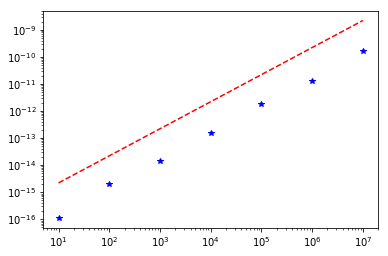

In [12]:
# Test: `experiment_results`
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

s = [1., 10., 100., 1000., 10000., 100000., 1000000.] # exact sums
t_minus_s_rel = [(t_i - s_i) / s_i for s_i, t_i in zip (s, t)]
rel_err_computed = [abs(r) for r in t_minus_s_rel]
rel_err_bound = [ni*EPS_D for ni in N]

# Plot of the relative error bound
plt.loglog (N, rel_err_computed, 'b*', N, rel_err_bound, 'r--')

print("Relative errors in the computed result:")
display (pd.DataFrame ({'n': N, 'rel_err': rel_err_computed, 'rel_err_bound': [n*EPS_D for n in N]}))

assert all([abs(r) <= n*EPS_D for r, n in zip(t_minus_s_rel, N)])

print("\n(Passed!)")

## Computing dot products

Let $x$ and $y$ be two vectors of length $n$, and denote their dot product by $f(x, y) \equiv x^T y$.

Now suppose we store the values of $x$ and $y$ _exactly_ in two Python arrays, `x[0:n]` and `y[0:n]`. Further suppose we compute their dot product by the program, `alg_dot()`.

In [14]:
def alg_dot (x, y):
    p = [xi*yi for (xi, yi) in zip (x, y)]
    s = alg_sum (p)
    return s

**Exercise 1** (OPTIONAL -- 0 points, not graded or collected). Show under what conditions `alg_dot()` is backward stable.

> _Hint._ Let $(x_k, y_k)$ denote the exact values of the corresponding inputs, $(\mathtt{x}[k], \mathtt{y}[k])$. Then the true dot product, $x^T y = \sum_{l=0}^{n-1} x_l y_l$. Next, let $\hat{p}_k$ denote the $k$-th computed product, i.e., $\hat{p}_k \equiv x_k y_k (1 + \gamma_k)$, where $\gamma_k$ is the $k$-th round-off error and $|\gamma_k| \leq \epsilon$. Then apply the results for `alg_sum()` to analyze `alg_dot()`.

**Answer.** Following the hint, `alg_sum` will compute $\hat{s}_{n-1}$ on the _computed_ inputs, $\{\hat{p}_k\}$. Thus,

$$
\begin{eqnarray}
  \hat{s}_{n-1}
    & \approx &
      \sum_{l=0}^{n-1} \hat{p}_l (1 + \Delta_l) \\
    & = &
      \sum_{l=0}^{n-1} x_l y_l (1 + \gamma_l) (1 + \Delta_l) \\
    & = &
      \sum_{l=0}^{n-1} x_l y_l (1 + \gamma_l + \Delta_l + \gamma_l \Delta_l).
\end{eqnarray}
$$

Mathematically, this appears to be the exact dot product to an input in which $x$ is exact and $y$ is perturbed (or vice-versa). To argue that `alg_dot` is backward stable, we need to establish under what conditions the perturbation, $\left| \gamma_l + \Delta_l + \gamma_l \Delta_l \right|$, is "small." Since $|\gamma_l| \leq \epsilon$ and $|\Delta_l| \leq n \epsilon$,

$$
  \left| \gamma_l + \Delta_l + \gamma_l \Delta_l \right|
  \leq | \gamma_l | + | \Delta_l | + |\gamma_l| \cdot |\Delta_l|
  \leq (n+1) \epsilon + \mathcal{O}(n \epsilon^2)
  \approx (n+1) \epsilon.
$$

## More accurate summation

Suppose you wish to compute the sum, $s = x_0 + x_1 + x_2 + x_3$. Let's say you use the "standard algorithm," which accumulates the terms one-by-one from left-to-right, as done by `alg_sum()` above.

For the standard algorithm, let the $i$-th addition incur a roundoff error, $\delta_i$. Then our usual error analysis would reveal that the absolute error in the computed sum, $\hat{s}$, is approximately:

$$
\begin{array}{rcl}
  \hat{s} - s
    & \approx &
      x_0(\delta_0 + \delta_1 + \delta_2 + \delta_3)
      + x_1(\delta_1 + \delta_2 + \delta_3)
      + x_2(\delta_2 + \delta_3)
      + x_3\delta_3.
\end{array}
$$

And since $|\delta_i| \leq \epsilon$, you would bound the absolute value of the error by,

$$
\begin{array}{rcl}
  \left| \hat{s} - s \right|
    & \lesssim &
      (4|x_0| + 3|x_1| + 2|x_2| + 1|x_3|)\epsilon.
\end{array}
$$

Notice that $|x_0|$ is multiplied by 4, $|x_1|$ by 3, and so on.

In general, if there are $n$ values to sum, the $|x_i|$ term will be multiplied by $n-i$.

**Exercise 2** (3 points). Based on the preceding observation, implement a new summation function, `alg_sum_accurate(x)` that computes a more accurate sum than `alg_sum()`.

In [16]:
def alg_sum_accurate(x):
    assert type(x) is list
#
# YOUR CODE HERE

    partials = []               # sorted, non-overlapping partial sums
    for n in x:
        i = 0
        for y in partials:
            if abs(n) < abs(y):
                n, y = y, n
            hi = n + y
            lo = y - (hi - n)
            if lo:
                partials[i] = lo
                i += 1
            n = hi
        partials[i:] = [n]
    return sum(partials, 0.0)
#alg_sum_accurate(x)

1000000.0

In [17]:
# Test: `alg_sum_accurate_test`
from math import exp
from numpy.random import lognormal

print("Generating non-uniform random values...")
N = [10, 10000, 10000000]
x = [lognormal(-10.0, 10.0) for _ in range(max(N))]
print("Range of input values: [{}, {}]".format(min(x), max(x)))

print("Computing the 'exact' sum. May be slow so please wait...")
x_exact = [Decimal(x_i) for x_i in x]
s_exact = [float(sum(x_exact[:n])) for n in N]
print("==>", s_exact)

print("Running alg_sum()...")
s_alg = [alg_sum(x[:n]) for n in N]
print("==>", s_alg)

print("Running alg_sum_accurate()...")
s_acc = [alg_sum_accurate(x[:n]) for n in N]
print("==>", s_acc)

print("Summary of relative errors:")
ds_alg = [abs(s_a - s_e) / s_e for s_a, s_e in zip(s_alg, s_exact)]
ds_acc = [abs(s_a - s_e) / s_e for s_a, s_e in zip(s_acc, s_exact)]
display (pd.DataFrame ({'n': N,
                        'rel_err(alg_sum)': ds_alg,
                        'rel_err(alg_sum_accurate)': ds_acc}))

assert all([r_acc < r_alg for r_acc, r_alg in zip(ds_acc[1:], ds_alg[1:])]), \
       "The 'accurate' algorithm appears to be less accurate than the conventional one!"

print("\n(Passed!)")

Generating non-uniform random values...
Range of input values: [3.951174426091217e-27, 4.0872724216595526e+20]
Computing the 'exact' sum. May be slow so please wait...
==> [481.6083962841983, 2624395123671.086, 4.123464744129364e+20]
Running alg_sum()...
==> [481.60839628419836, 2624395123671.055, 4.123464744127396e+20]
Running alg_sum_accurate()...
==> [481.6083962841983, 2624395123671.086, 4.123464744129364e+20]
Summary of relative errors:


,n,rel_err(alg_sum),rel_err(alg_sum_accurate)
0,10,1.180283e-16,0.0
1,10000,1.172145e-14,0.0
2,10000000,4.772797e-13,0.0



(Passed!)


**Done!** You have reached the end of Part 1. There are no additional parts, so if you are satisfied, be sure to submit both parts, declare victory, and move on!